# VCC predictions post processing
Here we explore post processing of the pertubation predictions that were produced via inference of the VCC data.      

We explore several techniques:  
1) Compare the predictions to a baseline predictions (mean expression for the gene across the entire train data) and overriding predicted expressions that
are very close to the baseline with the baseline itelf (i.e "unpredict noise predictions"). We tested absolute difference comparison and relative change comparison, and discover that overriding abosulte difference smaller than 0.5 improve the overall total socre in several points.    
2) Cap outlier predictions to 75%/90% expressions of that gene. This had a small improvement.  
3) compute 4096 HVG genes of the train data, and predict only these (override the rest to baseline). This decrease the total score.   


In [36]:
import numpy as np
import pandas as pd
import scanpy as sc

from bmfm_targets.datasets.base_perturbation_dataset import BasePerturbationDataset

In [37]:
from bmfm_targets.datasets.perturbation.vcc_postprocessing import (
    cap_outlier_predictions,
    override_noise_prediction_with_baseline,
)

### Load predictions h5ad file and the train data file

In [ ]:
results_file = "/proj/bmfm/users/thrumbel/vcc/expts/perturbx/all/perturbation/scbert_perturbx_all_logn/10092025/random_8192_predictions.h5ad"
train_file = "/proj/bmfm/datasets/vcc/internal_split/train_and_test_09162025_processed.h5ad"

In [39]:
res_adata = sc.read_h5ad(results_file)
res_adata.shape

(100913, 18080)

In [40]:
res_X = res_adata[res_adata.obs['target_gene'] != 'non-targeting'].X.toarray()

In [41]:
print(f"Min: {res_X.min():.4f}")
print(f"Mean: {res_X.mean():.4f}")
print(f"Max: {res_X.max():.4f}")

Min: 0.0000
Mean: 0.4453
Max: 5.8438


### Compute baseline values - mean expressions per gene across train data

In [42]:
train_adata = sc.read_h5ad(train_file)
train_adata.shape

(221273, 18080)

In [43]:
train_adata.obs["internal_split_for_test"].value_counts()

internal_split_for_test
train    120360
test      62737
Name: count, dtype: int64

In [44]:
train_group_means = BasePerturbationDataset.make_group_means(train_adata, perturbation_column_name = "target_gene", split_column_name= "internal_split_for_test")

/u/sivanra/git/bmfm-targets/bmfm_targets/datasets/base_perturbation_dataset.py:159: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ad.obs.groupby(perturbation_column_name)


In [45]:
baseline = train_group_means.processed_data.to_df().loc["Average_Perturbation_Train"]
baseline

SAMD11     0.000244
NOC2L      0.694937
KLHL17     0.158151
PLEKHN1    0.054209
PERM1      0.000396
             ...   
MT-ND4L    0.132683
MT-ND4     1.884135
MT-ND5     0.059067
MT-ND6     0.924160
MT-CYB     0.652072
Name: Average_Perturbation_Train, Length: 18080, dtype: float32

In [46]:
baseline.describe()

count    18080.000000
mean         0.769553
std          0.881731
min          0.000000
25%          0.015937
50%          0.416774
75%          1.329287
max          5.977043
Name: Average_Perturbation_Train, dtype: float64

In [47]:
np.percentile(baseline, [5, 10, 25, 50])

array([6.84681687e-05, 3.91406016e-04, 1.59365358e-02, 4.16773990e-01])

### (1) Explore replacing predictions with baseline if difference is samller than a threshold ("unpredicting" noise predictions)

In [48]:
from pathlib import Path

res_folder = Path("/proj/bmfm/users/sivanra/vcc_score")

In [ ]:
# create post-processed files with replacement to baseline in various threshold
# both absolute and relative
# Note, this takes a while
import os

#absolute
absolute_th = [0.01, 0.1, 0.3, 0.4, 0.5, 0.6, 1, 2, 10] 
for th in absolute_th:
    file_num = f"{th}".replace(".","") 
    file = res_folder / f"res_{file_num}.h5ad"
    if not os.path.exists(file):
        print(f"computing: {file}")
        res = override_noise_prediction_with_baseline(res_adata, baseline, absolute=True, threshold=th)
        print(f"writing: {file}")
        res.write_h5ad(file)

### run cell-eval manualy to generate the metrics for each file

Note we are using `train_and_test_09162025_processed_test_only.h5ad` version that has the test data and the control only

```bash
cell-eval run -ap /proj/bmfm/users/sivanra/vcc_score/res_03.h5ad -ar /proj/bmfm/datasets/vcc/internal_split/train_and_test_09162025_processed_test_only.h5ad --num-threads 64 --pert-col target_gene --profile vcc -o /proj/bmfm/users/sivanra/vcc_score/cell_eval_res_03
```

In [50]:
all_results = []
for th in absolute_th + ["orig"] : 
    file_num = f"{th}".replace(".","") 
    cell_eval_res = res_folder / f"cell_eval_res_{file_num}" / "agg_results.csv"
    if os.path.exists(cell_eval_res):
        res = pd.read_csv(cell_eval_res)
        res["absolute_diff_th"] = th
        all_results.append(res[res["statistic"]=="mean"])
abs_summary_df = pd.concat(all_results, ignore_index=True)
abs_summary_df['absolute_diff_th'] = abs_summary_df['absolute_diff_th'].replace('orig', 0)
abs_summary_df = abs_summary_df.drop("statistic" ,  axis=1)
abs_summary_df


/tmp/ipykernel_97608/2095413448.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  abs_summary_df['absolute_diff_th'] = abs_summary_df['absolute_diff_th'].replace('orig', 0)


,overlap_at_N,mae,discrimination_score_l1,absolute_diff_th
0,0.254200,0.830364,0.5600,0.01
1,0.261519,0.830111,0.5620,0.10
2,0.262070,0.826422,0.5892,0.30
3,0.263278,0.820819,0.6068,0.40
4,0.265561,0.808960,0.6068,0.50
5,0.272015,0.781508,0.5956,0.60
6,0.305155,0.609344,0.5720,1.00
7,0.204793,0.240849,0.5116,2.00
8,0.000000,0.028166,0.5116,10.00
9,0.238990,0.830345,0.5584,0.00


In [51]:
baseline_mae = 0.028 # 0.026
baseline_pds = 0.5116 # 0.512
baseline_des = 0 # 0.106 
def add_final_metrics(summary_df, th_col):
    summary_df["scaled_mae"] = ((baseline_mae - summary_df["mae"])/baseline_mae).clip(0)
    summary_df["scaled_des"] = ((summary_df["overlap_at_N"] - baseline_des)/(1 - baseline_des)).clip(0)
    summary_df["scaled_pds"] = ((summary_df["discrimination_score_l1"] - baseline_pds)/(1 - baseline_pds)).clip(0)
    summary_df["final_score"] = (summary_df["scaled_mae"]+summary_df["scaled_pds"]+summary_df["scaled_des"])/3*100
    summary_df[[th_col, "overlap_at_N","mae","discrimination_score_l1","scaled_des","scaled_mae","scaled_pds","final_score"]]

In [52]:

add_final_metrics(abs_summary_df, "absolute_diff_th")
abs_summary_df.sort_values("absolute_diff_th")

,overlap_at_N,mae,discrimination_score_l1,absolute_diff_th,scaled_mae,scaled_des,scaled_pds,final_score
9,0.238990,0.830345,0.5584,0.00,0.0,0.238990,0.095823,11.160420
0,0.254200,0.830364,0.5600,0.01,0.0,0.254200,0.099099,11.776627
1,0.261519,0.830111,0.5620,0.10,0.0,0.261519,0.103194,12.157096
2,0.262070,0.826422,0.5892,0.30,0.0,0.262070,0.158886,14.031881
3,0.263278,0.820819,0.6068,0.40,0.0,0.263278,0.194922,15.273332
4,0.265561,0.808960,0.6068,0.50,0.0,0.265561,0.194922,15.349445
5,0.272015,0.781508,0.5956,0.60,0.0,0.272015,0.171990,14.800184
6,0.305155,0.609344,0.5720,1.00,0.0,0.305155,0.123669,14.294124
7,0.204793,0.240849,0.5116,2.00,0.0,0.204793,0.000000,6.826449
8,0.000000,0.028166,0.5116,10.00,0.0,0.000000,0.000000,0.000000


We see that "unpredicting" expressions smaller than 0.5 give +4.2 boost to the total score

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_th_scores(summary_df, th_col):
    summary_df = summary_df.sort_values(th_col)

    # Define groups of metrics
    metrics = ['overlap_at_N', 'mae', 'discrimination_score_l1']
    score_metric = 'final_score'

    sns.set_theme(style='whitegrid')
    palette = sns.color_palette('Set2', n_colors=len(metrics))

    # --- Figure 1: metrics (0–1 range) ---
    plt.figure(figsize=(8, 5))
    for metric, color in zip(metrics, palette):
        plt.plot(summary_df[th_col], summary_df[metric],
                marker='o', linewidth=2.5, markersize=7,
                label=metric, color=color)

    plt.ylim(0, 1)
    plt.xlabel(th_col, fontsize=12)
    plt.ylabel('Value ', fontsize=12)
    plt.title('Model Performance', fontsize=14, weight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Metric', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- Figure 2: final_score (0–50 range) ---
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=summary_df, x=th_col, y=score_metric,
                marker='o', linewidth=2.5, color='royalblue')

    plt.ylim(0, 50)
    plt.xlabel(th_col, fontsize=12)
    plt.ylabel('Final Score ', fontsize=12)
    plt.title('Final Score', fontsize=14, weight='bold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

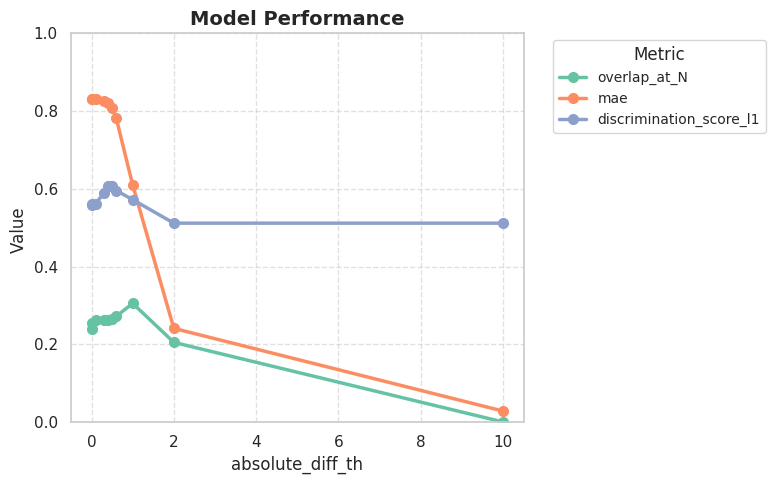

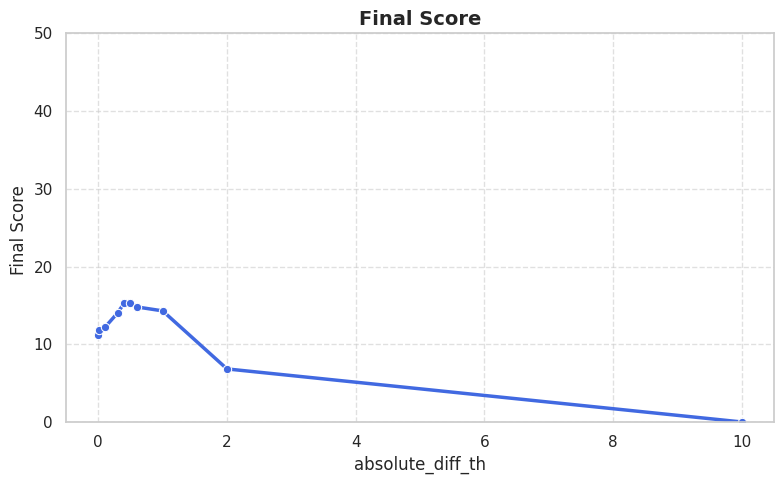

In [54]:
plot_th_scores(abs_summary_df, "absolute_diff_th")

## Repeat for relative th

In [ ]:
#relative
relative_th = [0.02, 0.05, 0.08, 0.1, 0.2, 1, 2,5,10000000]
for th in relative_th:
    file_num = f"{th}".replace(".","") 
    file = res_folder / f"res_rel_{file_num}.h5ad"
    if not os.path.exists(file):
        print(f"computing: {file}")
        res = override_noise_prediction_with_baseline(res_adata, baseline, absolute=False, threshold=th)
        print(f"writing: {file}")
        res.write_h5ad(file)

In [56]:
all_rel_results = []
for th in relative_th + ["orig"] : 
    file_num = f"{th}".replace(".","") 
    cell_eval_res = res_folder / f"cell_eval_res_rel_{file_num}" / "agg_results.csv"
    if os.path.exists(cell_eval_res):
        res = pd.read_csv(cell_eval_res)
        res["relative_diff_th"] = th
        all_rel_results.append(res[res["statistic"]=="mean"])
rel_summary_df = pd.concat(all_rel_results, ignore_index=True)
rel_summary_df['relative_diff_th'] = rel_summary_df['relative_diff_th'].replace('orig', 0)
rel_summary_df = rel_summary_df.drop("statistic" ,  axis=1)
rel_summary_df

/tmp/ipykernel_97608/4016708704.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rel_summary_df['relative_diff_th'] = rel_summary_df['relative_diff_th'].replace('orig', 0)


,overlap_at_N,mae,discrimination_score_l1,relative_diff_th
0,0.059986,0.061474,0.5124,0.02
1,0.059986,0.061474,0.5124,0.05
2,0.238862,0.830039,0.5600,0.10
3,0.238145,0.828154,0.5620,0.20
4,0.182718,0.696122,0.5664,1.00
5,0.151795,0.267496,0.5152,2.00
6,0.137260,0.233859,0.5140,5.00
7,0.000000,0.028166,0.5116,10000000.00
8,0.238990,0.830345,0.5584,0.00


In [57]:
add_final_metrics(rel_summary_df, "relative_diff_th")
rel_summary_df.sort_values("relative_diff_th")

,overlap_at_N,mae,discrimination_score_l1,relative_diff_th,scaled_mae,scaled_des,scaled_pds,final_score
8,0.238990,0.830345,0.5584,0.00,0.0,0.238990,0.095823,11.160420
0,0.059986,0.061474,0.5124,0.02,0.0,0.059986,0.001638,2.054138
1,0.059986,0.061474,0.5124,0.05,0.0,0.059986,0.001638,2.054138
2,0.238862,0.830039,0.5600,0.10,0.0,0.238862,0.099099,11.265382
3,0.238145,0.828154,0.5620,0.20,0.0,0.238145,0.103194,11.377961
4,0.182718,0.696122,0.5664,1.00,0.0,0.182718,0.112203,9.830703
5,0.151795,0.267496,0.5152,2.00,0.0,0.151795,0.007371,5.305529
6,0.137260,0.233859,0.5140,5.00,0.0,0.137260,0.004914,4.739141
7,0.000000,0.028166,0.5116,10000000.00,0.0,0.000000,0.000000,0.000000


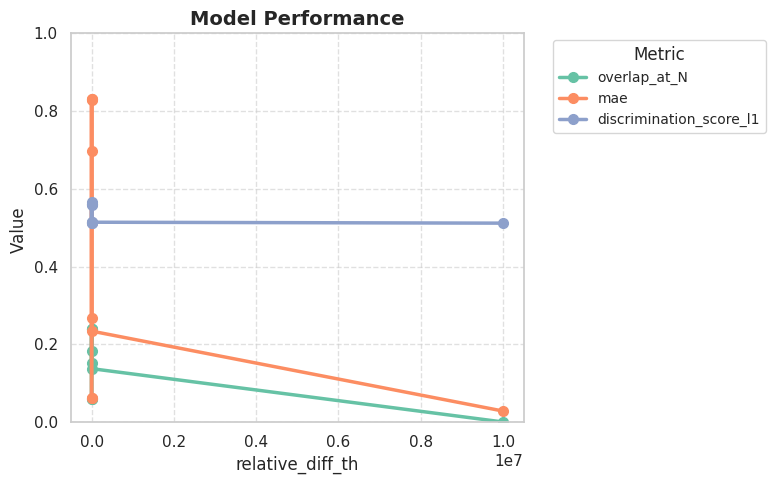

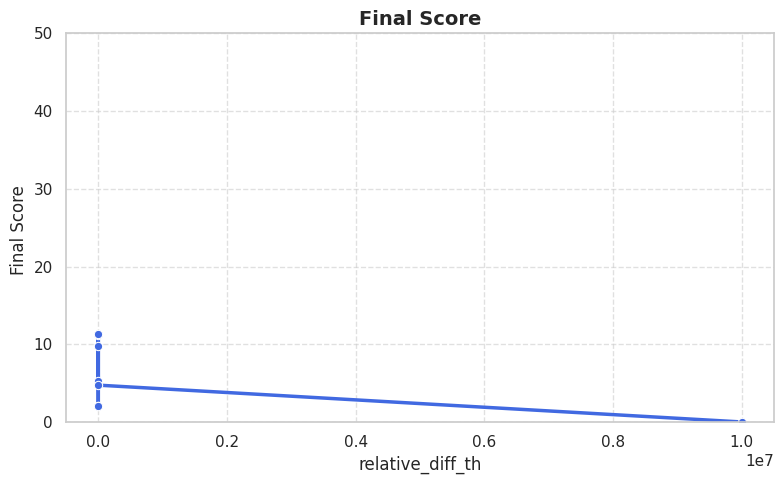

In [58]:
plot_th_scores(rel_summary_df, "relative_diff_th")

Here we didn't get an increase in the scores.. might need a more delicate post processing

## (2) Capping of outlier predictions

Here we test if capping of very high predictions improves score.  
We load two h5ad files, the original results and the top "unpredict_abs-0.5" results.  
for each, we test capping  all predictions higher than 75%/90% predictions value for that Gene. 

In [59]:
import os
from pathlib import Path

import pandas as pd
import scanpy as sc
import scipy.sparse as sp

In [60]:
res_folder = Path("/proj/bmfm/users/sivanra/vcc_score")

In [61]:
results_file = "/proj/bmfm/users/thrumbel/vcc/expts/perturbx/all/perturbation/scbert_perturbx_all_logn/10092025/random_8192_predictions.h5ad"
unpredict_05_file = "/proj/bmfm/users/sivanra/vcc_score/res_05.h5ad"

In [62]:
res_adata = sc.read_h5ad(results_file)
res_adata_unpredict_05 = sc.read_h5ad(unpredict_05_file)

In [63]:

def compute_quantiles(adata):
    """Compute quantiles while ignoring zero expressions."""
    X = adata.X
    if sp.issparse(X):
        X = X.toarray()
    qdf = pd.DataFrame(X, columns=adata.var_names, index=adata.obs_names)

    # Compute per-gene quantiles excluding zeros
    quantile_df = (
        qdf.apply(lambda x: x[x > 0].quantile([0.5, 0.75, 0.9]))
        .T.rename(columns={0.5: "50%", 0.75: "75%", 0.9: "90%"})
    )

    return quantile_df

In [64]:
# res_adata_quant = compute_quantiles(res_adata[res_adata.obs["target_gene"]!='non-targeting'])
# res_adata_quant

In [65]:
# res_adata_unpredict_05_quants = compute_quantiles(res_adata_unpredict_05[res_adata_unpredict_05.obs["target_gene"]!='non-targeting'])
# res_adata_unpredict_05_quants

In [66]:
# takes time..
output_file = Path(res_folder) / "res_orig_cap075.h5ad"
if not os.path.exists(output_file):
    res_adata_cap75 = cap_outlier_predictions(res_adata, output_file, 0.75)
else:
    res_adata_cap75 = sc.read_h5ad(output_file)


In [67]:
#sanity
compute_quantiles(res_adata_cap75)

,50%,75%,90%
SAMD11,0.385742,1.342773,1.342773
NOC2L,0.827277,1.273542,1.273542
KLHL17,0.620245,0.689717,0.689724
PLEKHN1,0.679210,0.754655,0.754655
PERM1,0.000396,0.000396,0.000396
...,...,...,...
MT-ND4L,1.440068,1.527822,1.527822
MT-ND4,4.386719,4.554688,4.554688
MT-ND5,3.093458,3.120713,3.120713
MT-ND6,1.545898,1.743164,1.743164


In [68]:
output_file = Path(res_folder) / "res_orig_cap090.h5ad"
if not os.path.exists(output_file):
    res_adata_cap90 = cap_outlier_predictions(res_adata, output_file, 0.90)
else:
   res_adata_cap90 = sc.read_h5ad(output_file)

In [69]:
output_file = Path(res_folder) / "res_05_cap075.h5ad"
if not os.path.exists(output_file):
    res_adata_unpredict_05_cap75 = cap_outlier_predictions(res_adata_unpredict_05, output_file, 0.75)
else:
    res_adata_unpredict_05_cap75 = sc.read_h5ad(output_file)

output_file = Path(res_folder) / "res_05_cap090.h5ad"
if not os.path.exists(output_file):
    res_adata_unpredict_05_cap90 = cap_outlier_predictions(res_adata_unpredict_05, output_file, 0.90)
else:
    res_adata_unpredict_05_cap90 = sc.read_h5ad(output_file)



-- manually run cell-eval as before --
cell-eval run -ap /proj/bmfm/users/sivanra/vcc_score/res_05_cap090.h5ad -ar /proj/bmfm/datasets/vcc/internal_split/train_and_test_09162025
_processed_test_only.h5ad --num-threads 64 --pert-col target_gene --profile vcc -o /proj/bmfm/users/sivanra/vcc_score/cell_eval_res_05_cap090

load cell_eval results:

In [70]:

cappping_all_results = []
suffixes = {"": 0,
            "_cap075": 0.75,
            "_cap090": 0.90} 
for suffix, th in suffixes.items():
    file_num = f"{th}".replace(".","") 
    cell_eval_res = res_folder / f"cell_eval_res_orig{suffix}" / "agg_results.csv"
    if os.path.exists(cell_eval_res):
        res = pd.read_csv(cell_eval_res)
        res["capping_th"] = th
        cappping_all_results.append(res[res["statistic"]=="mean"])
capping_summary_df = pd.concat(cappping_all_results, ignore_index=True)
capping_summary_df = capping_summary_df.drop("statistic" ,  axis=1)
capping_summary_df

,overlap_at_N,mae,discrimination_score_l1,capping_th
0,0.238990,0.830345,0.5584,0.00
1,0.176633,0.799489,0.5616,0.75
2,0.205939,0.818644,0.5620,0.90


In [71]:
add_final_metrics(capping_summary_df, "capping_th")
capping_summary_df.sort_values("capping_th")

,overlap_at_N,mae,discrimination_score_l1,capping_th,scaled_mae,scaled_des,scaled_pds,final_score
0,0.238990,0.830345,0.5584,0.00,0.0,0.238990,0.095823,11.160420
1,0.176633,0.799489,0.5616,0.75,0.0,0.176633,0.102375,9.300256
2,0.205939,0.818644,0.5620,0.90,0.0,0.205939,0.103194,10.304453


load cell_eval results for abs_05 capping:

In [72]:

cappping_05_all_results = []
suffixes = {"": 0,
            "_cap075": 0.75,
            "_cap090": 0.90} 
for suffix, th in suffixes.items():
    file_num = f"{th}".replace(".","") 
    cell_eval_res = res_folder / f"cell_eval_res_05{suffix}" / "agg_results.csv"
    if os.path.exists(cell_eval_res):
        res = pd.read_csv(cell_eval_res)
        res["capping_th"] = th
        cappping_05_all_results.append(res[res["statistic"]=="mean"])
capping_05_summary_df = pd.concat(cappping_05_all_results, ignore_index=True)
capping_05_summary_df = capping_05_summary_df.drop("statistic" ,  axis=1)
capping_05_summary_df

,overlap_at_N,mae,discrimination_score_l1,capping_th
0,0.265561,0.808960,0.6068,0.00
1,0.233333,0.749227,0.5584,0.75
2,0.242669,0.785289,0.6560,0.90


In [73]:
add_final_metrics(capping_05_summary_df, "capping_th")
capping_05_summary_df.sort_values("capping_th")

,overlap_at_N,mae,discrimination_score_l1,capping_th,scaled_mae,scaled_des,scaled_pds,final_score
0,0.265561,0.808960,0.6068,0.00,0.0,0.265561,0.194922,15.349445
1,0.233333,0.749227,0.5584,0.75,0.0,0.233333,0.095823,10.971858
2,0.242669,0.785289,0.6560,0.90,0.0,0.242669,0.295659,17.944275


#### --> Overriding with absolute th=0.5 then capping to 90% gives the highest increase of almost 7 points in total score.

## (3) Use HVG genes

In [74]:
import os
from pathlib import Path

import pandas as pd
import scanpy as sc

In [75]:
res_folder = Path("/proj/bmfm/users/sivanra/vcc_score")

In [76]:
def add_hvg_on_train(fname, var_dir, split_col, split_val="train"):
    ad = sc.read_h5ad(fname)
    ad_train = ad[ad.obs[split_col]==split_val].copy()
    sc.pp.highly_variable_genes(
        ad_train,
        flavor='seurat',
        #n_top_genes=4096,
        subset=False,
        inplace=True
    )
    # Merge back 
    ad.var = ad.var.join(ad_train.var[['highly_variable', 'dispersions', 'dispersions_norm', 'means']], how='left')

    # Fill missing dispersion values for non-train genes
    ad.var['dispersions'] = ad.var['dispersions'].fillna(-1)
    ad.var['dispersions_norm'] = ad.var['dispersions_norm'].fillna(-1)
    ad.var['means'] = ad.var['means'].fillna(-1)
    ad.var['highly_variable'] = ad.var['highly_variable'].fillna(False)

    var_file_name = var_dir +"/"+ os.path.basename(fname).replace(".h5ad",".hvg.var.csv")
    ad.var.to_csv(var_file_name)
    print(f"Var metadata saved to: {var_file_name}")
    new_h5ad = fname.replace(".h5ad",".with_hvg.h5ad")
    ad.write_h5ad(new_h5ad)

    print(f"adata with train var saved to {new_h5ad}")
    

In [77]:
train_file = "/proj/bmfm/datasets/vcc/internal_split/train_and_test_09162025_processed.h5ad"

In [78]:
vcc_var_dir = "/proj/bmfm/datasets/vcc/internal_split/var"
#os.mkdir(vcc_var_dir)

In [79]:
# no need to run again cause we saved them to the file
#add_hvg_on_train(train_file, vcc_var_dir, split_col= "internal_split_for_test", split_val ="train")

In [80]:
adata_with_hvg_file = "/proj/bmfm/datasets/vcc/internal_split/train_and_test_09162025_processed.with_hvg.h5ad"
adata_with_hvg = sc.read_h5ad(adata_with_hvg_file)

In [81]:
adata_with_hvg

AnnData object with n_obs × n_vars = 221273 × 18080
    obs: 'target_gene', 'guide_id', 'batch', 'internal_split', 'internal_split_for_test'
    var: 'highly_variable', 'dispersions', 'dispersions_norm', 'means'
    uns: 'log1p', 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'

In [82]:
adata_with_hvg.var.sort_values("dispersions", ascending=False)

,highly_variable,dispersions,dispersions_norm,means
LEUTX,False,5.484771,14.112729,3.098652e-03
H3.Y,False,5.477957,14.094394,2.299503e-03
KRT6B,False,4.744246,12.120141,1.588711e-03
CLEC4M,False,4.688637,11.970510,2.999388e-03
CER1,True,4.643820,11.849916,1.643845e-01
...,...,...,...,...
SPACA7,False,-1.000000,-1.000000,1.000000e-12
OR9I1,False,-1.000000,-1.000000,1.000000e-12
CLEC3B,False,-1.000000,-1.000000,1.000000e-12
LCE3E,False,-1.000000,-1.000000,1.000000e-12


In [83]:
adata_with_hvg.var.sort_values("dispersions_norm", ascending=False)

,highly_variable,dispersions,dispersions_norm,means
DAZL,True,3.976020,18.554592,0.385134
SLC16A3,True,2.521406,14.172528,0.781653
LEUTX,False,5.484771,14.112729,0.003099
H3.Y,False,5.477957,14.094394,0.002300
LEFTY1,True,2.757250,13.495610,0.908391
...,...,...,...,...
OR5H15,False,-0.637561,-2.361109,0.000004
PLG,False,-0.658422,-2.417242,0.000008
OR1L6,False,-0.723797,-2.593152,0.000004
NUTM2E,False,-0.771876,-2.722522,0.000004


In [84]:
adata_with_hvg.var.sort_values("means", ascending=False)

,highly_variable,dispersions,dispersions_norm,means
ACTB,False,2.543714,1.000000,5.987716e+00
CD24,False,2.554370,1.000000,5.469583e+00
POU5F1,False,1.627658,1.000000,5.121439e+00
EEF2,False,1.861188,-0.494191,4.975424e+00
HSPA8,False,2.873945,1.053071,4.874991e+00
...,...,...,...,...
LCE3E,False,-1.000000,-1.000000,1.000000e-12
OR4N5,False,-1.000000,-1.000000,1.000000e-12
OR11H4,False,-1.000000,-1.000000,1.000000e-12
DEFB115,False,-1.000000,-1.000000,1.000000e-12


In [85]:
adata_with_hvg.var["highly_variable"].value_counts()

highly_variable
False    16417
True      1663
Name: count, dtype: int64

In [86]:
adata_with_hvg[:,adata_with_hvg.var["highly_variable"]==True].var["dispersions"].describe()

count    1663.000000
mean        0.712707
std         0.456096
min         0.332640
25%         0.447542
50%         0.575009
75%         0.791679
max         4.643820
Name: dispersions, dtype: float64

In [87]:
adata_with_hvg.var["dispersions"].describe()

count    18080.000000
mean         0.297517
std          0.328370
min         -1.000000
25%          0.156400
50%          0.227792
75%          0.335421
max          5.484771
Name: dispersions, dtype: float64

In [88]:
def replace_non_hvg_with_baseline(adata, hvg_adata, baseline_vector, var="dispersions", quantile=0.05):
    """Replace expressions of non hvg genes with baseline values."""
    baseline = np.array(baseline_vector)
    
    if len(baseline) != hvg_adata.n_vars:
        raise ValueError(f"Baseline vector length ({len(baseline)}) must match number of genes ({hvg_adata.n_vars})")
    if var not in hvg_adata.var:
        raise KeyError(f"'{var}' not found in hvg_adata.var")

    if not np.array_equal(adata.var_names, hvg_adata.var_names):
        raise ValueError("Gene order or names differ between adata and hvg_adata — align before calling this function.")

    adata = adata.copy()
    X = adata.X
    is_sparse = hasattr(X, "toarray")
    X_dense = X.toarray() if is_sparse else np.array(X, dtype=float)
    
    baseline_broadcast = baseline[np.newaxis, :] # make it [1,n_genes]
   

    # compute mask based on hvg data
    vals = hvg_adata.var[var].values
    cutoff = np.quantile(vals, 1 - quantile)
    mask = vals >= cutoff
    print(f"quantile: {quantile}, cutoff: {cutoff}, replacing {sum(~mask)} genes")
    baseline_full = np.broadcast_to(baseline_broadcast, X_dense.shape)
    X_dense[:, ~mask] = baseline_full[:, ~mask]

    if is_sparse:
        from scipy.sparse import csr_matrix
        X_new = csr_matrix(X_dense)
    else:
        X_new = X_dense
    
    adata.X = X_new
     
    print(f"Kept top {quantile*100:.1f}% HVG genes ({mask.sum()} genes), replaced {adata.n_vars - mask.sum()} with baseline.")
    return adata

In [89]:
results_file = "/proj/bmfm/users/thrumbel/vcc/expts/perturbx/all/perturbation/scbert_perturbx_all_logn/10092025/random_8192_predictions.h5ad"
res_adata = sc.read_h5ad(results_file)

In [90]:
suffixes = ["orig"]
for quantile in [0.1,0.2, 0.3,0.5, 0.6, 0.7, 0.8, 0.9]:
    suffix = f"hvg_dispersions_quantile_{quantile}"
    output_file = res_folder / f"res_{suffix}.h5ad"
    suffixes.append(suffix)
    if not os.path.exists(output_file):
        print(f"creating: {output_file}")
        res_adata_quantile = replace_non_hvg_with_baseline(res_adata, adata_with_hvg, baseline, "dispersions", quantile)
        res_adata_quantile.write_h5ad(output_file)
    else:
        print(f"already exist: {output_file}")
        #res_adata_quantile = sc.read_h5ad(output_file)

already exist: /proj/bmfm/users/sivanra/vcc_score/res_hvg_dispersions_quantile_0.1.h5ad
already exist: /proj/bmfm/users/sivanra/vcc_score/res_hvg_dispersions_quantile_0.2.h5ad
already exist: /proj/bmfm/users/sivanra/vcc_score/res_hvg_dispersions_quantile_0.3.h5ad
already exist: /proj/bmfm/users/sivanra/vcc_score/res_hvg_dispersions_quantile_0.5.h5ad
already exist: /proj/bmfm/users/sivanra/vcc_score/res_hvg_dispersions_quantile_0.6.h5ad
already exist: /proj/bmfm/users/sivanra/vcc_score/res_hvg_dispersions_quantile_0.7.h5ad
already exist: /proj/bmfm/users/sivanra/vcc_score/res_hvg_dispersions_quantile_0.8.h5ad
already exist: /proj/bmfm/users/sivanra/vcc_score/res_hvg_dispersions_quantile_0.9.h5ad


cell-eval run -ap /proj/bmfm/users/sivanra/vcc_score/res_hvg_dispersions_quantile_0.3.h5ad -ar /proj/bmfm/datasets/vcc/internal_split/train_and_test_09162025_processed_test_only.h5ad --num-threads 64 --pert-col target_gene --profile vcc -o /proj/bmfm/users/sivanra/vcc_score/cell_eval_res_hvg_dispersions_quantile_0.3 --de-real cell_eval_res_orig/real_de.csv

In [91]:
suffixes

['orig',
 'hvg_dispersions_quantile_0.1',
 'hvg_dispersions_quantile_0.2',
 'hvg_dispersions_quantile_0.3',
 'hvg_dispersions_quantile_0.5',
 'hvg_dispersions_quantile_0.6',
 'hvg_dispersions_quantile_0.7',
 'hvg_dispersions_quantile_0.8',
 'hvg_dispersions_quantile_0.9']

In [92]:

hvg_all_results = []
for suffix in suffixes:
    cell_eval_res = res_folder / f"cell_eval_res_{suffix}" / "agg_results.csv"
    if os.path.exists(cell_eval_res):
        res = pd.read_csv(cell_eval_res)
        res["hvg"] = suffix
        hvg_all_results.append(res[res["statistic"]=="mean"])
hvg_summary_df = pd.concat(hvg_all_results, ignore_index=True)
hvg_summary_df = hvg_summary_df.drop("statistic" ,  axis=1)
hvg_summary_df

,overlap_at_N,mae,discrimination_score_l1,hvg
0,0.238990,0.830345,0.5584,orig
1,0.149913,0.157293,0.5108,hvg_dispersions_quantile_0.1
2,0.223141,0.284276,0.5140,hvg_dispersions_quantile_0.2
3,0.255010,0.390223,0.5140,hvg_dispersions_quantile_0.3
4,0.280390,0.558933,0.5256,hvg_dispersions_quantile_0.5
5,0.277758,0.627533,0.5516,hvg_dispersions_quantile_0.6
6,0.265618,0.687226,0.5520,hvg_dispersions_quantile_0.7
7,0.253785,0.739953,0.5572,hvg_dispersions_quantile_0.8
8,0.242037,0.791163,0.5648,hvg_dispersions_quantile_0.9


In [ ]:
add_final_metrics(hvg_summary_df, "hvg")
hvg_summary_df.sort_values("hvg")

,overlap_at_N,mae,discrimination_score_l1,hvg,scaled_mae,scaled_des,scaled_pds,final_score
1,0.149913,0.157293,0.5108,hvg_dispersions_quantile_0.1,0.0,0.149913,0.000000,4.997113
2,0.223141,0.284276,0.5140,hvg_dispersions_quantile_0.2,0.0,0.223141,0.004914,7.601838
3,0.255010,0.390223,0.5140,hvg_dispersions_quantile_0.3,0.0,0.255010,0.004914,8.664145
4,0.280390,0.558933,0.5256,hvg_dispersions_quantile_0.5,0.0,0.280390,0.028665,10.301849
5,0.277758,0.627533,0.5516,hvg_dispersions_quantile_0.6,0.0,0.277758,0.081900,11.988600
6,0.265618,0.687226,0.5520,hvg_dispersions_quantile_0.7,0.0,0.265618,0.082719,11.611245
7,0.253785,0.739953,0.5572,hvg_dispersions_quantile_0.8,0.0,0.253785,0.093366,11.571693
8,0.242037,0.791163,0.5648,hvg_dispersions_quantile_0.9,0.0,0.242037,0.108927,11.698803
0,0.238990,0.830345,0.5584,orig,0.0,0.238990,0.095823,11.160420


: 

#### --> This tehcnique did not improve the results